<a href="https://colab.research.google.com/github/jpcompartir/dl_notebooks/blob/main/keras_apis_seq_func_subc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras APIs three layers of abstraction: sequential , functional, subclassing (in order of simplicity).

The simplicty of the sequential abstraction comes at a cost, it is basically a Python list limiting it to simple stacks of layers. The function API is a graph-like model architecture, and perhaps provides the best balance between simplicity & flexibility; this may be why it is the most commonly used API. The subclassing API involves building everything from scratch, and should be used when a model architecture cannot be formulated as a graph. All three layers are compatible with one another.

The sequential API:

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

#Instantiating a model with two dense layers, with the final being a softmax classification head.
model = keras.Sequential([
    layers.Dense(64, activation = "relu"),
    layers.Dense(10, activation = "softmax")
])



In [ ]:
#Alternative method is to instantiate a model and add each layer:
model = keras.Sequential()
model.add(layers.Dense(64, activation = "relu"))
model.add(layers.Dense(10, activation = "softmax"))

The layers are not built (create weights) instantly - because the shape of the layers is input-dependent and at the time of instantiating the model we have no input data, so do not know the shape the layers should be. Which is another way of saying the model has no weights, we could check that by calling model.weights.

Calling our model for the first time will build its weights:

In [4]:
model.build(input_shape = (None, 3)) #None signals that batch size could be anything, 3 signals the expected shape of the inputs
#Call this once model is built to get the model's summary - layers, output sahpes, # of parameters - total & trainable/non-trainable


In [ ]:
model.weights



In [ ]:
 model.summary() 

The model summary will show that each layer has a name like sequential_1, we could have named each layer with the name = "foo_bar" argument when creating each sequential layer.

When we make changes to a model it's helpful to print a summary to check our changes have occurred as we expected. However, currently the model will not build until it's called on data (reminder that we need to know the input dims). One way to get around this is to set the input dimensions in advance, which we can do with model.add(keras.Input(shape = (3,))), after calling model = keras.Sequential(), we can then call model.summary() as and when we please.

The Functional API:

When we want models that can deal with multiple inputs and provide multiple outputs, or to customize our model/deal with bespoke problems etc. we need to turn to the functional API. 

In [9]:
inputs = keras.Input(shape = (3,), name = "my_input")

inputs.shape
inputs.dtype

features = layers.Dense(64, activation = "relu")(inputs)

features.shape

outputs = layers.Dense(10, activation = "softmax")(features)
model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In this case inputs is a symbolic tensor; it carries information about what type of dimensions our model should expect but it contains no data. We can think of it as setting the constraints of our model, or the rules of the game - if we try to feed our model something that does not fit these dimensions then the model will halt. 

Chollet says 'it stands for future tensors of data'.

However, this model is simple and could be achived with the sequential API. The functional API shines when dealing with a graph-like structure, i.e. it's able to deal with multiple inputs and do different things with each one.

Let's say if building a text classification model for customer support tickets - a model could take three inputs:
* Title of the ticket (text input)
* Text body of the ticket (text input)
* Tags added by the user (categorical input that should be one-hot encoded)

One way of encoding the texts would be to create binary arrays of size_vocabulary.

The model will produce two outputs:
* Priority score of the ticket (sigmoid/logistic output)
* Department that should handle the ticket (softmax over the set of departments)

Building the model with the functional API:

In [11]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape = (vocabulary_size,), name = "title")
text_body = keras.Input(shape = (vocabulary_size,), name = "text_body")
tags = keras.Input(shape = (num_tags,), name = "tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation = "relu")(features)

priority = layers.Dense(1, activation = "sigmoid", name = "priority")(features)
department = layers.Dense(num_departments, activation = "softmax", name = "department")(features)

model = keras.Model(inputs = [title, text_body, tags],
                   outputs = [priority,department])


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        

Above we set parameters of inputs - vocabulary size, number of tags and number of departments.

Then we set the shape of each input and name them respectively.

We create features by concatenating our inputs, then create a 64-deep Dense layer with a relu activation.

We feed our features into a sigmoid classification head to get our priority score (between 0 & 1), and we feed those same features into a softmax classification head to extract which department (a probability distribution - i.e. the score of all 4 adds up to 1).

The next step would be to train our model, there are multiple methods - calling fit with lists of input and output data, or training a model with dicts of input and target arrays. Calling with lists relies on input order, so we can use dicts to call with names.


In [19]:
#Training model by providiung lists of input & target arrays
import numpy as np
num_samples = 1280

# Dummy input data.
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# Dummy target data.
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))
model.compile(optimizer='adam',
              loss=['mean_squared_error', 'categorical_crossentropy'],
              metrics=[['mean_absolute_error'], ['accuracy']])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 5ms/step - loss: 3.7903 - priority_loss: 0.3299 - department_loss: 3.4604 - priority_mean_absolute_error: 0.5016 - department_accuracy: 0.1906


In [21]:
#Training model by providing dicts of input and target arrays
model.compile(optimizer = "rmsprop",
             loss = {"priority":"mean_squared_error", "department": "categorical_crossentropy"},
             metrics = {"priority": ["mean_absolute_error"], "department":["accuracy"]})

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
         {"priority": priority_data, "department": department_data}, epochs = 1)


model.evaluate({"title": title_data, "text_body": text_body_data,
               "tags": tags_data},
              {"priority": priority_data, "department": department_data})

priority_preds, department_preds = model.predict(
{"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 5ms/step - loss: 7.8149 - priority_loss: 0.3299 - department_loss: 7.4851 - priority_mean_absolute_error: 0.5016 - department_accuracy: 0.1516


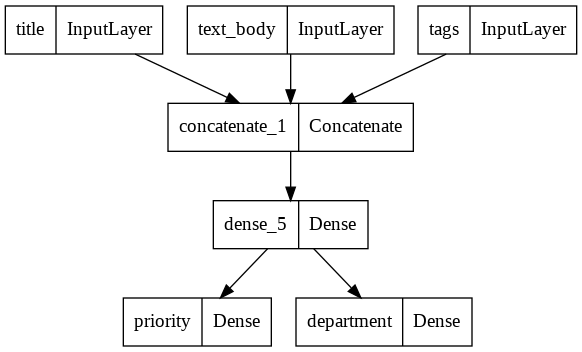

In [22]:
keras.utils.plot_model(model, "ticket_classifier.png")

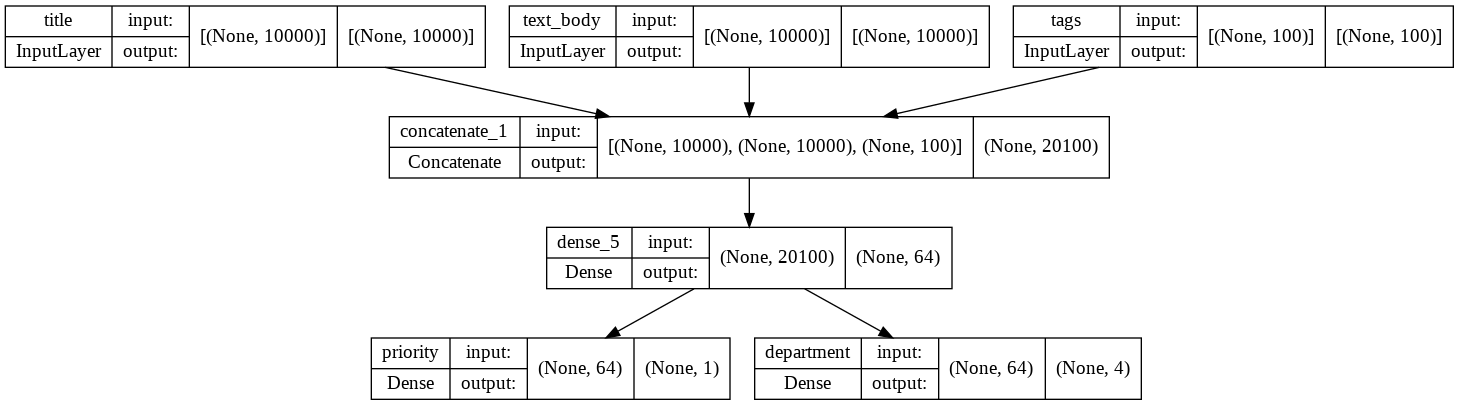

In [24]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes = True)

Feature extraction - using intermediate layers/representations to feed into another model. For example, if we wanted to add another classification head to fulfil a different ask, we could use the layers of our pre-trained model rather than training from scratch.

In [25]:
model.layers

In [26]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [27]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate_1')>

In [28]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation='softmax', name='difficulty')(features)
new_model = keras.Model(
  inputs=[title, text_body, tags],
  outputs=[priority, department, difficulty])

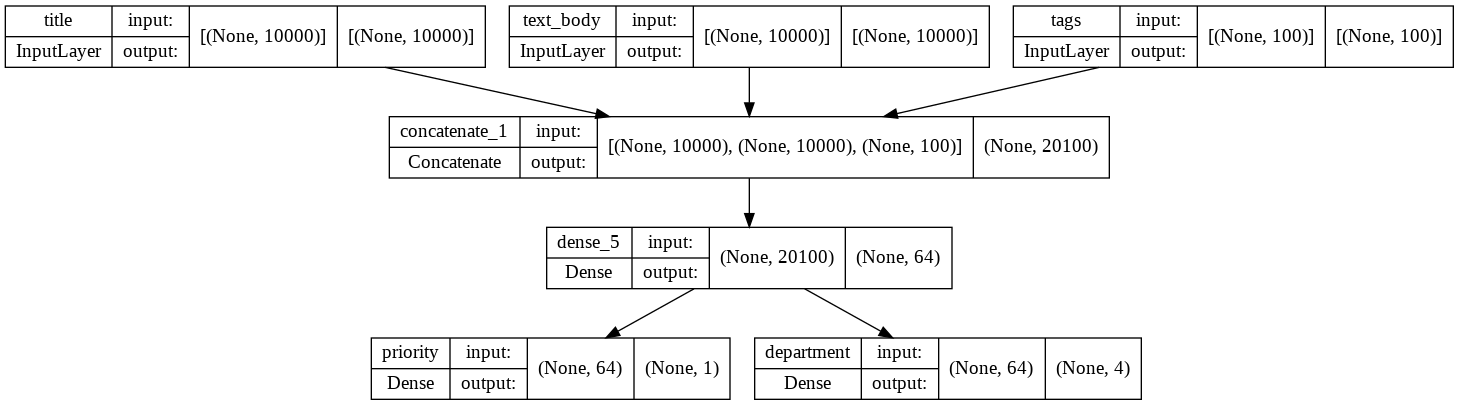

In [29]:
        keras.utils.plot_model(model, "updated_ticket_classifier.png", show_shapes=True)